# Imports + Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

plt.rcParams.update({'figure.figsize':(11,7), 'figure.dpi':120})
image_dest = 'results_images/'
visual_specs={'fontsize':14, 'palette':'Greys', 'saturation':0.5}
fontsize = visual_specs['fontsize']
palette = visual_specs['palette']
datapath = '../Data/'

id_col = 'SPA_PER_ID'
event_col = 'CMIS_MATCH'

# Load Predictions

In [2]:
filename = 'log_predictions.pickle'
infile = open(datapath+filename,'rb')
log_predictions = pickle.load(infile)
infile.close()

print(len(log_predictions))

log_predictions.head()

84345


,SPA_PER_ID,prediction,CMIS_MATCH
0,3,0.002089,False
1,4,0.001236,False
2,6,0.002334,False
3,12,0.001311,False
4,14,0.001866,False


In [3]:
filename = 'log_weighted_predictions.pickle'
infile = open(datapath+filename,'rb')
log_weighted_predictions = pickle.load(infile)
infile.close()

print(len(log_weighted_predictions))

log_weighted_predictions.head()

84345


,SPA_PER_ID,linear,exp,CMIS_MATCH
0,3,0.001737,0.001735,False
1,4,0.001183,0.001181,False
2,6,0.001923,0.001916,False
3,12,0.001255,0.001241,False
4,14,0.001821,0.001808,False


In [4]:
log_weighted_predictions.isnull().sum()

SPA_PER_ID    0
linear        0
exp           0
CMIS_MATCH    0
dtype: int64

# ROC Curve

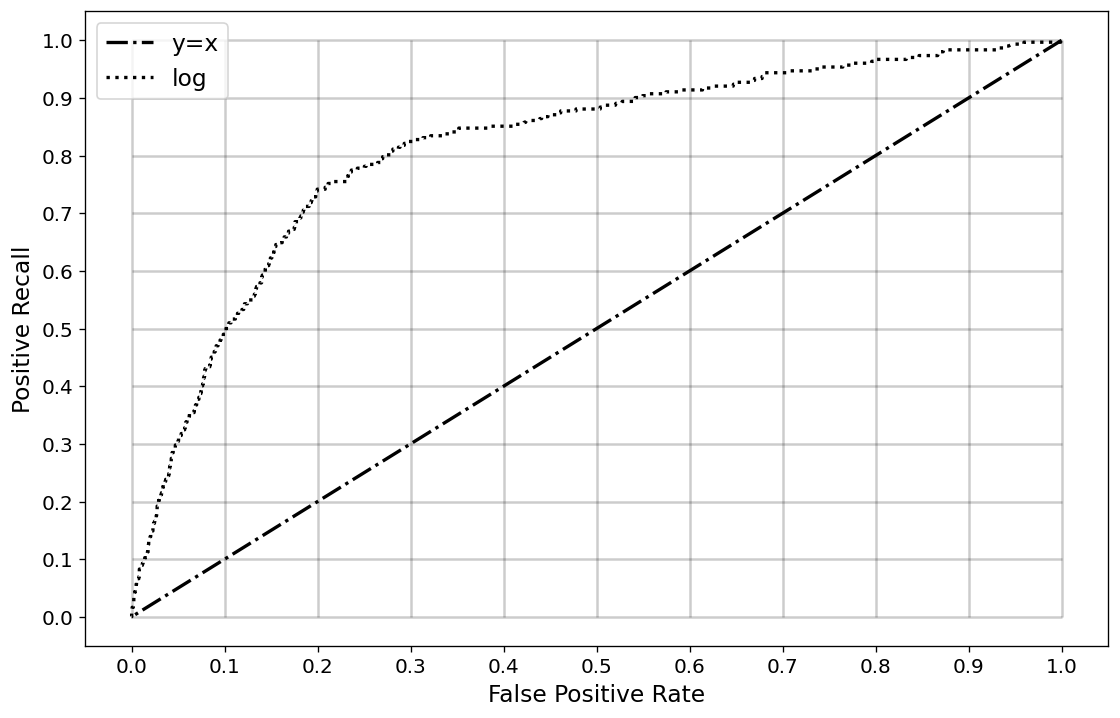

In [6]:
linewidth = 2
color = 'black'
alpha=0.2

# Refernce line
plt.plot([1,0], [1,0], color='black', label='y=x', linestyle='dashdot', linewidth=linewidth)

# Log
fpr, tpr, _ = roc_curve(y_true=log_predictions[event_col].astype('bool'), y_score=log_predictions['prediction'])
plt.plot(fpr, tpr, color='black', label='log', linestyle='dotted', linewidth=linewidth)

# Linearly weighted predictions
#fpr, tpr, _ = roc_curve(y_true=log_weighted_predictions[event_col].astype('bool'), y_score=log_weighted_predictions['linear'])
#plt.plot(fpr, tpr, color='red', label='log_linear', linestyle='dotted', linewidth=linewidth)

# Exponentially weighted predictions
#fpr, tpr, _ = roc_curve(y_true=log_weighted_predictions[event_col].astype('bool'), y_score=log_weighted_predictions['exp'])
#plt.plot(fpr, tpr, color='red', label='log_linear', linestyle='dotted', linewidth=linewidth)


ticks = np.arange(0,1.1,0.1)
plt.hlines(y=ticks, xmin=0, xmax=1, colors=color, alpha=alpha)
plt.vlines(x=ticks, ymin=0, ymax=1, colors=color, alpha=alpha)
plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.xticks(ticks, fontsize=fontsize-2)
plt.ylabel('Positive Recall', fontsize=fontsize)
plt.yticks(ticks, fontsize=fontsize-2)
plt.legend(fontsize=fontsize)
plt.savefig(fname=image_dest+'ROC.png', bbox_inches='tight')
plt.show()

## Explanation
### Positive Recall
Vertical axis  
Of the predicted positives, how many are correct?
$$
Positive Recall =
\frac{True Positives}{True Positives + False Positives}
$$
### False Positive Rate
Horizontal axis  
AKA False Alarm Rate  
Of the negatives, how many are misclassified as positive?
$$
False Positive Rate = 
\frac{False Positives}{All Negatives}
$$